In [1]:
import glob
import logging
import os

from keras.callbacks import (
    EarlyStopping,
    TerminateOnNaN,
    ModelCheckpoint,
)
from keras.layers import (
    Dense,
    Dropout,
    CuDNNLSTM,
)
from keras.layers.wrappers import Bidirectional
from keras.models import Sequential
from keras.utils import Sequence
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from sklearn.utils import class_weight

%matplotlib inline

Using TensorFlow backend.


In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
MAX_HISTORY = 48
N_FEATURES = 59
MAX_CARDS_IN_DRAW_PILE = 13

In [4]:
class TrainingSequence(Sequence):
    def __init__(self, directory: str):
        self.batches = sorted(glob.glob(os.path.join(directory, "batch_*.npz")))
        logging.debug("Found %d batches in %s", len(self.batches), directory)

    def __len__(self):
        return len(self.batches)

    def __getitem__(self, idx):
        logging.debug("Loading batch %d", idx)
        batch = np.load(self.batches[idx])
        n_samples = len(batch["X"]) // MAX_HISTORY // N_FEATURES
        X = batch["X"].reshape((n_samples, MAX_HISTORY, N_FEATURES))
        y = batch["y"].reshape((n_samples, MAX_CARDS_IN_DRAW_PILE))
        return X, y

In [5]:
def build_model(input_shape: tuple, output_shape: int):
    model = Sequential([
        Bidirectional(CuDNNLSTM(128, return_sequences=False),
                      input_shape=input_shape),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(output_shape, activation='softmax'),
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    return model


def train(model, data, val_data):
    history = model.fit_generator(
        data,
        epochs=50,
        validation_data=data,
        use_multiprocessing=True,
        workers=8,
        max_queue_size=16,
        callbacks=[
            EarlyStopping(
                monitor='val_loss', min_delta=0.005, patience=3,
                restore_best_weights=True),
            TerminateOnNaN(),
        ],
    )

    return model, history

In [6]:
data_dir = '/home/timpalpant/go/src/github.com/timpalpant/alphacats/model'
data = TrainingSequence(os.path.join(data_dir, 'train-samples'))
val_data = TrainingSequence(os.path.join(data_dir, 'val-samples'))
test_data = TrainingSequence(os.path.join(data_dir, 'test-samples'))

X, y = data[0]
input_shape = X[0].shape
output_shape = y[0].shape[0]
model = build_model(input_shape, output_shape)
print(model.summary())

model, history = train(model, data, val_data)
model.save('model.hd5')

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 256)               193536    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 13)                1677      
Total params: 244,621
Trainable params: 244,621
Non-trainable params: 0
_________________________________________________________________
None

Instructions for updating:
Use tf.cast instead.


Epoch 1/50
1000/1000 [==============================] - 353s 353ms/step - loss: 2.0718 - acc: 0.2255 - val_loss: 1.9485 - val_acc: 0.2574
Epoch 2/50
1000/1000 [==============================] - 347s 347ms/step - loss: 1.9634 - acc: 0.2562 - val_loss: 1.9338 - val_acc: 0.2611
Epoch 3/50
1000/1000 [==============================] - 347s 347ms/step - loss: 1.9474 - acc: 0.2600 - val_loss: 1.9509 - val_acc: 0.2609
Epoch 4/50
1000/1000 [==============================] - 348s 348ms/step - loss: 1.9431 - acc: 0.2603 - val_loss: 1.9293 - val_acc: 0.2600
Epoch 5/50
1000/1000 [==============================] - 349s 349ms/step - loss: 1.9490 - acc: 0.2611 - val_loss: 1.9458 - val_acc: 0.2604


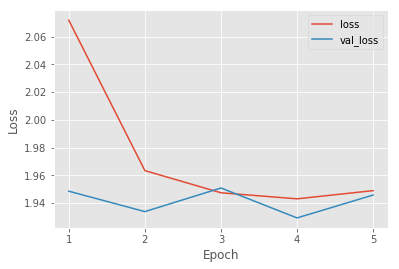

In [7]:
h = history.history
epochs = np.arange(len(h['loss'])) + 1
plt.plot(epochs, h['loss'], label='loss')
plt.plot(epochs, h['val_loss'], label='val_loss')
plt.xticks(epochs)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [8]:
predicted = model.predict_generator(test_data)

In [9]:
actual = test_data[0][1]
pred = predicted[:len(actual)]

- Fig 1: Normal learning equal probability for each and not to predict invalid positions
- Fig 2: See the future with exploding kitten + reset after shuffle
- Fig 3: See the future with no kitten + reset after shuffle
- Fig 4: Insert exploding kitten + know its position exactly + shift after draws
- Fig 5: Other player inserts kitten

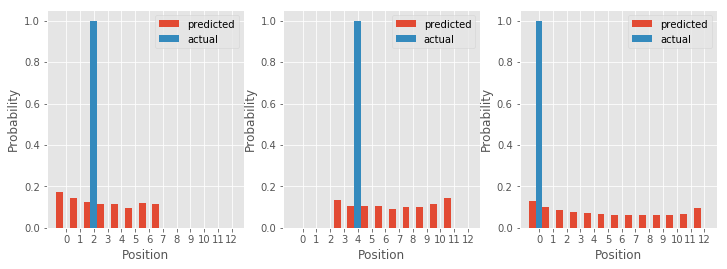

In [11]:
positions = np.arange(MAX_CARDS_IN_DRAW_PILE)
i = 10

plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.bar(positions, pred[i], width=0.5, label='predicted')
plt.bar(positions+0.5, actual[i], width=0.5, label='actual')
plt.xticks(positions+0.5, positions)
plt.xlabel('Position')
plt.ylabel('Probability')
plt.legend()

plt.subplot(1, 3, 2)
plt.bar(positions, pred[i+1], width=0.5, label='predicted')
plt.bar(positions+0.5, actual[i+1], width=0.5, label='actual')
plt.xticks(positions+0.5, positions)
plt.xlabel('Position')
plt.ylabel('Probability')
plt.legend()

plt.subplot(1, 3, 3)
plt.bar(positions, pred[i+2], width=0.5, label='predicted')
plt.bar(positions+0.5, actual[i+2], width=0.5, label='actual')
plt.xticks(positions+0.5, positions)
plt.xlabel('Position')
plt.ylabel('Probability')
plt.legend()